# "Classifiez automatiquement des biens de consommation"
_NLP Cleaning Notebook_

In [ ]:
# import subprocess
# subprocess.call("".split())pip install -U opencv-python

0

In [ ]:
!pip install -U opencv-python

     |████████████████████████████████| 49.5MB 86kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


SIFT code is adapted from:
https://towardsdatascience.com/image-stitching-using-opencv-817779c86a83


In [ ]:
from random import randrange
import cv2
figsize = (10, 10)

In [ ]:
cv2.__version__

'4.4.0'

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
from google.colab import files, output, drive
import os

In [2]:
drive.mount('/gdrive')
%cd /gdrive
os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')

Mounted at /gdrive
/gdrive


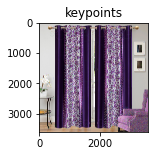

In [ ]:
import cv2

img = cv2.imread("../DATA/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg")

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

# create the feature extractor
feature_extractor = cv2.SIFT_create()
# find the keypoints and descriptors with chosen feature_extractor
kp, desc = feature_extractor.detectAndCompute(gray, None)

test = cv2.drawKeypoints(rgb, kp,
                         None,
                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(5,2))
plt.imshow(test)
plt.title("keypoints")
plt.show()

### 0.1 Importing the datasets

In [ ]:
df = pd.read_csv("../DATA/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')

## 1 Image pre-processing

In [ ]:
import dill
# df_image = dill.load(open('df_image.pkl', mode='rb'))
dict_images = dill.load(open('dict_images.pkl', mode='rb'))

### 3.2 Clustering on a bag of visual words (SIFT, SURF, ORB)

In [ ]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

#### Extracts local features from images

The below function returns an array whose first index holds a list that holds all local features from all images without an order. This is our visual dictionary. And the second index holds the sift vectors dictionary which holds the descriptors but this is separated class by class

In [ ]:
# Creates descriptors using sift 
# Takes one parameter that is images dictionary
# Return an array whose first index holds the decriptor_list without an order
# And the second index holds the sift_vectors dictionary which holds
# the descriptors but this is seperated class by class

def sift_features(images):
    dict_sift_descriptors, dict_keypoints = {}, {}
    all_descriptors_list = []
    sift = cv2.xfeatures2d.SIFT_create() # cv2.
    for key,img in images.items():
        features = []
        kp, des = sift.detectAndCompute(img,None)
        all_descriptors_list.extend(des)
        dict_sift_descriptors[key] = des
        dict_keypoints[key] = kp
    return dict_keypoints, dict_sift_descriptors, all_descriptors_list

# def get_descriptors(image_path):
#     # load image and convert it to grayscale
#     img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     # detect key points and descriptors
#     keypoints, descriptors = model.detectAndCompute(img_gray, None)
#     # returns keypoints and descriptors
#     return keypoints, descriptors

In [ ]:
# Store descriptors and bovw features 
# keypoints_list, descriptor_list, all_bovw_feature = sift_features(dict_images) 
dict_keypoints, dict_sift_descriptors, all_descriptors_list = \
                                             sift_features(dict_images) 

In [ ]:
# import dill
# dill.dump((dict_sift_descriptors, all_descriptors_list),
#           open("descriptors.pkl", "wb"))

In [ ]:
import dill
dict_sift_descriptors, all_descriptors_list  = \
    dill.load(open("descriptors.pkl", "rb"))

In [ ]:
# print("list of the keypoints", len(keypoints_list))
print("list of all the descriptors: ", len(all_descriptors_list))
print("dictionary giving all the descriptors (vectors) for each image: ",
      len(dict_sift_descriptors.keys()))

#### Selects the visual words

Send the visual dictionary to the k-means clustering algorithm and find the visual words which are center points.

In [ ]:
# A k-means clustering algorithm who takes 2 parameter which is number 
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.

from sklearn.cluster import KMeans

def descriptors_cluster_centers(k, descriptors_list):
    clusterer = KMeans(n_clusters = k, n_init=10)
    clusterer.fit(descriptors_list)
    visual_words = clusterer.cluster_centers_ 
    return visual_words, clusterer

In [ ]:
# # Takes the central points which is visual words   

# visual_words, desc_clusterer = descriptors_cluster_centers(150,
#                                                            all_descriptors_list)
# visual_words.shape

In [ ]:
# import dill
# dill.dump((visual_words, desc_clusterer), open("visual_words.pkl", "wb"))

In [ ]:
import dill
visual_words, desc_clusterer = dill.load(open("visual_words.pkl", "rb"))

In [ ]:
# détermine pour chaque image a quel cluster appartient les descripteurs
# renvoie un dictionnaire avec la liste des numéros des clusters parmi 150
# convertit le dictionnaire en pd.Series, puis en dataframe (multilabelbinarizer)
vw_list = []
ind_img_list = []
for n_img, desc_list in dict_sift_descriptors.items():
    vwords = desc_clusterer.predict(desc_list) # liste des numéros des visuals words de l'image
    vw_list.append(vwords) # liste des listes de vw pour toutes les images
    ind_img_list.append(n_img) # liste des index des images

In [ ]:
from collections import Counter
df_visual_words = pd.DataFrame([Counter(x) for x in vw_list],
                               index = ind_img_list).fillna(0)
df_visual_words = df_visual_words[sorted(df_visual_words.columns)]

In [ ]:
df_visual_words

#### KMeans clustering on the BoVW

In [ ]:
# Data selection to train clusterer (HSV 224x224 pixels)
X_df = df_visual_words
print("Size of the training data :", X_df.shape)

In [ ]:
# Visualization of the images (BoVW of 150 VW) on a t-SNE projection

ser_categories = pd.Series(df_pict['category'].values, 
                           index=df_pict.index,
                           name='Clust')

plot_projection(X_df, model=None, ser_clust=ser_categories,
                proj='t-SNE', size=10, legend_on=True,
                title="Projection t-SNE of the pictures\n(Bag of 150 VirtualWords)",
                figsize=(10, 6), palette='tab10',
                fig=None, ax=None, random_state=14)

In [ ]:
# Create the model
from sklearn.cluster import KMeans
k=7 # number of categories
km = KMeans(n_clusters=k) 

In [ ]:
# Fitting the Kmeans model
km.fit(X_df)

In [ ]:
# Appending the best results of the Kmeans clustering
df_res_clust['KMclust_Bo150VW'] = km.labels_

In [ ]:
df_res_clust.sample(5)

# Creation of a bag of visual words

### Load train and test images into dictionaries.

In [ ]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

In [ ]:
# plt.imshow(dict_images['7b72c92c2f6c40268628ec5f14c6d590'])

In [ ]:
from PIL.Image import fromarray

### Extracts local features from images using SIFT.

The below function returns an array whose first index holds a list that holds all local features from all images without an order. This is our visual dictionary. And the second index holds the sift vectors dictionary which holds the descriptors but this is separated class by class

In [ ]:
# Creates descriptors using sift 
# Takes one parameter that is images dictionary
# Return an array whose first index holds the decriptor_list without an order
# And the second index holds the sift_vectors dictionary which holds the descriptors but this is seperated class by class
def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,img in images.items():
        print(key)
        features = []
        print(img.shape)
        # img = Image.fromarray(img)
        kp, des = sift.detectAndCompute(img,None)
        descriptor_list.extend(des)
        features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

# def get_descriptors(image_path):
#     # load image and convert it to grayscale
#     img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     # detect key points and descriptors
#     keypoints, descriptors = model.detectAndCompute(img_gray, None)
#     # returns keypoints and descriptors
#     return keypoints, descriptors

In [ ]:
import cv2
detector = cv2.xfeatures2d.SIFT_create()

In [ ]:
sifts = sift_features(dict_images) 
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
# test_bovw_feature = sift_features(test)[1] 

In [ ]:
STOP

In [ ]:
df_image

### Find the visual words 

Send the visual dictionary to the k-means clustering algorithm and find the visual words which are center points.

In [ ]:

# A k-means clustering algorithm who takes 2 parameter which is number 
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
# Takes the central points which is visual words    
visual_words = kmeans(150, descriptor_list) 

### Create histograms

In [ ]:

# Takes 2 parameters. The first one is a dictionary that holds the descriptors that are separated class by class 
# And the second parameter is an array that holds the central points (visual words) of the k means clustering
# Returns a dictionary that holds the histograms for each images that are separated class by class. 
def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    
# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words) 

## Predict classes of the test images with k-NN function.

In [ ]:

# 1-NN algorithm. We use this for predict the class of test images.
# Takes 2 parameters. images is the feature vectors of train images and tests is the feature vectors of test images
# Returns an array that holds number of test images, number of correctly predicted images and records of class based images respectively
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    
# Call the knn function    
results_bowl = knn(bovw_train, bovw_test) 

## Calculate the accuracy

In [ ]:

# Calculates the average accuracy and class based accuracies.  
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))
        
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl) 
view rawaccuracy.py hosted with ❤ by GitHub

'/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS'

In [13]:
import pandas as pd
from sklearn.cluster import KMeans

In [6]:
import dill as pickle
with open('dict_best_df.pkl', 'rb') as file:
    dict_dfs = pickle.load(file)

In [ ]:
df_res = pd.read_csv("true_categories.csv", index_col='Unnamed: 0')

In [17]:
km = KMeans(n_clusters=7, random_state=14)
res = km.fit_predict(dict_dfs['N02_preproc_dimred_km'])
df_res['res_1'] = res
km = KMeans(n_clusters=7, random_state=24)
res = km.fit_predict(dict_dfs['N02_preproc_dimred_km'])
df_res['res_2'] = res

In [ ]:
categ_identificator(df_res[['res_1', 'res_2']], true_cat=None)

# Exportation

Now we export the dataset of aggregated orders in a .csv file.